We have our data obtained from the publicly available IMDB datasets. The data was stored in an SQL Server database with three views created from complex queries that collated the required rows from the five tables. 
The data was prepared with feature engineering techniques and preliminary insepection. Then began the EDA phase with various plots and statistics developed to discover insights about the dataset. Finally, 4 methods were used for modelling, linear regression, linear regression with regularisation, random forest, and XGBoost. A few variations were tried with each of these but only the best were kept. The strongest model was XGboost with all variables included, no grid search and no interaction features. It had an R-squared of 0.805 and RMSE of 0.517.

In [ ]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import numpy as np

#connect to SQL Server
sqlServerName = 'DESKTOP-HNI1KAC'
databaseName = 'MovieRatings'
connenction_string = (f"DRIVER={{SQL Server}};"f"SERVER={sqlServerName};"f"DATABASE={databaseName};"f"Trusted_Connection={'yes'}")
try:
   conn = pyodbc.connect(connenction_string)
except pyodbc.Error as ex:
      print("An error occurred in SQL Server:", ex)

#load and output movie ratings data
moviesData = pd.read_sql(("SELECT * FROM MovieRatingsView ORDER BY averageRating DESC;"), conn)
moviesData.info()
moviesData.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43393 entries, 0 to 43392
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          43393 non-null  object 
 1   Runtime        43393 non-null  object 
 2   genres         43393 non-null  object 
 3   Year           43393 non-null  object 
 4   averageRating  43393 non-null  float64
 5   numvotes       43393 non-null  object 
 6   Actors         43393 non-null  object 
 7   Directors      43393 non-null  object 
 8   Writers        43393 non-null  object 
dtypes: float64(1), object(8)
memory usage: 3.0+ MB


,Title,Runtime,genres,Year,averageRating,numvotes,Actors,Directors,Writers
0,Kousalya Tanaya Ragava,147,\N,2025,9.5,1183,"nm10464666, nm17194763, nm9235817, nm9706424",nm17194765,nm17194765
1,Guru Nanak Jahaz,140,History,2025,9.4,3495,"nm1836657, nm4535968, nm7898625, nm8906441",nm6014257,"nm15160688, nm6014257"
2,Jibon Theke Neya,150,"Drama,Family",1970,9.3,2310,"nm0759619, nm1399007, nm2594993, nm2596180",nm2513556,"nm0403951, nm2513556"
3,Janam,129,Drama,2023,9.3,2170,"nm4886752, nm3846688, nm15432779, nm15432781",nm15432778,nm15432778
4,Bombay,135,Action,2025,9.3,1193,"nm0214358, nm3977986, nm6383559, nm9450833",nm9978220,nm9978220


In [3]:
#load and output actor ratings data
actorData = pd.read_sql(("SELECT * FROM ActorRatingsView ORDER BY ActorAverage DESC;"), conn)
actorData.info()
actorData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408385 entries, 0 to 408384
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ActorCode     408384 non-null  object 
 1   ActorAverage  408385 non-null  float64
 2   NumMovies     408385 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 9.3+ MB


,ActorCode,ActorAverage,NumMovies
0,nm5885123,10.0,1
1,nm16094594,10.0,1
2,nm17317313,10.0,1
3,nm4924649,10.0,1
4,nm11685453,10.0,1


In [4]:
#load and output crew ratings data
crewData = pd.read_sql(("SELECT * FROM CrewRatingsView ORDER BY AvgRating DESC;"), conn)
crewData.info()
crewData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356031 entries, 0 to 356030
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CrewCode   356030 non-null  object 
 1   Role       356031 non-null  object 
 2   AvgRating  356031 non-null  float64
 3   NumMovies  356031 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 10.9+ MB


,CrewCode,Role,AvgRating,NumMovies
0,nm4993952,writer,10.0,1
1,nm9144837,director,10.0,1
2,nm14635295,writer,10.0,1
3,nm12156145,director,10.0,1
4,nm17345788,director,10.0,1


##### Feature engineering: Multi-hot encoding genre and setting numerical data types

In [6]:
#Split genres into lists
moviesData['genres_list'] = moviesData['genres'].str.split(',')

#Extract all unique genres using a nested loop
all_genres = set(g for sublist in moviesData['genres_list'] for g in sublist)

#Create a multi-hot encoded DataFrame by checking if each genre is present in the list (x) for each movie
for genre in all_genres:
    moviesData[f'genre_{genre}'] = moviesData['genres_list'].apply(lambda x: int(genre in x))

print(all_genres)

#drop the temp list column
moviesData.drop(columns='genres_list', inplace=True)

{'Drama', 'Sport', 'Thriller', 'Sci-Fi', 'Musical', 'History', 'Crime', 'Biography', 'War', 'Mystery', 'Adventure', 'Comedy', 'Horror', 'Action', 'News', 'Film-Noir', 'Animation', 'Music', 'Fantasy', '\\N', 'Romance', 'Documentary', 'Adult', 'Family', 'Western'}


In [ ]:
#turn runtime, Year and numvotes into a numerical data type
moviesData['Runtime'] = moviesData['Runtime'].replace(['\\N'], '90')
moviesData['Runtime'] = moviesData['Runtime'].astype(int)
moviesData['Year'] = moviesData['Year'].astype(int)
moviesData['numvotes'] = moviesData['numvotes'].astype(int)

In [8]:
# Create dictionaries that contain actor/crew codes and their average ratings, for fast lookup
actor_rating_dict = dict(zip(actorData['ActorCode'], actorData['ActorAverage']))
director_rating_dict = dict(zip(crewData[crewData['Role'] == 'director']['CrewCode'], crewData[crewData['Role'] == 'director']['AvgRating']))
writer_rating_dict = dict(zip(crewData[crewData['Role'] == 'writer']['CrewCode'], crewData[crewData['Role'] == 'writer']['AvgRating']))

##### Create average ratings column for actors and crew

In [10]:
# Function to replace actor/crew codes with the average of their ratings, then take the average of those ratings
def average_code_ratings(code_list, rating_dict):
    if pd.isna(code_list):
        return None
    codes = [c.strip() for c in str(code_list).split(',')]
    ratings = [rating_dict.get(code, None) for code in codes if rating_dict.get(code, None) is not None]
    if not ratings:
        return None
    return sum(ratings) / len(ratings)

moviesData['actor_ratings'] = moviesData['Actors'].apply(lambda x: average_code_ratings(x, actor_rating_dict))
moviesData['director_ratings'] = moviesData['Directors'].apply(lambda x: average_code_ratings(x, director_rating_dict))
moviesData['writer_ratings'] = moviesData['Writers'].apply(lambda x: average_code_ratings(x, writer_rating_dict))

print(moviesData[['actor_ratings', 'director_ratings', 'writer_ratings']])
    

       actor_ratings  director_ratings  writer_ratings
0           8.133871          9.500000        9.500000
1           8.051693          7.440000        8.400000
2           7.432891          8.175000        7.911666
3           7.946429          9.300000        9.300000
4           7.167857          7.416666        7.816666
...              ...               ...             ...
43388       1.012500          1.025000        1.050000
43389       1.429167          1.000000        1.000000
43390       1.587500          2.850000        1.000000
43391       4.943333          5.434375        3.435714
43392       3.085000          2.850000        1.000000

[43393 rows x 3 columns]


# EDA

In [ ]:
# structure and summary stats
moviesData.info()
moviesData.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43393 entries, 0 to 43392
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              43393 non-null  object 
 1   Runtime            43393 non-null  int32  
 2   genres             43393 non-null  object 
 3   Year               43393 non-null  int32  
 4   averageRating      43393 non-null  float64
 5   numvotes           43393 non-null  int32  
 6   Actors             43393 non-null  object 
 7   Directors          43393 non-null  object 
 8   Writers            43393 non-null  object 
 9   genre_Drama        43393 non-null  int64  
 10  genre_Sport        43393 non-null  int64  
 11  genre_Thriller     43393 non-null  int64  
 12  genre_Sci-Fi       43393 non-null  int64  
 13  genre_Musical      43393 non-null  int64  
 14  genre_History      43393 non-null  int64  
 15  genre_Crime        43393 non-null  int64  
 16  genre_Biography    433

,Runtime,Year,averageRating,numvotes,genre_Drama,genre_Sport,genre_Thriller,genre_Sci-Fi,genre_Musical,genre_History,...,genre_Fantasy,genre_\N,genre_Romance,genre_Documentary,genre_Adult,genre_Family,genre_Western,actor_ratings,director_ratings,writer_ratings
count,43393.000000,43393.000000,43393.000000,4.339300e+04,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,...,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000,43393.000000
mean,105.517503,1999.788399,6.187950,2.656250e+04,0.579379,0.016546,0.158874,0.052543,0.017491,0.035167,...,0.055769,0.000576,0.175143,0.008895,0.000392,0.042657,0.014795,5.984030,6.094418,6.056445
std,22.319552,22.952003,1.165624,9.876218e+04,0.493664,0.127566,0.365562,0.223122,0.131094,0.184204,...,0.229478,0.023996,0.380094,0.093896,0.019789,0.202084,0.120733,0.660948,0.875125,0.847103
min,30.000000,1911.000000,1.000000,1.001000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.012500,1.000000,1.000000
25%,91.000000,1989.000000,5.600000,1.692000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.691667,5.645161,5.637500
50%,100.000000,2008.000000,6.400000,3.420000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073913,6.222666,6.200000
75%,115.000000,2017.000000,7.000000,1.119400e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.363787,6.661904,6.596666
max,439.000000,2025.000000,9.500000,3.053067e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.100000,9.500000,9.500000


### Ratings Visualisation

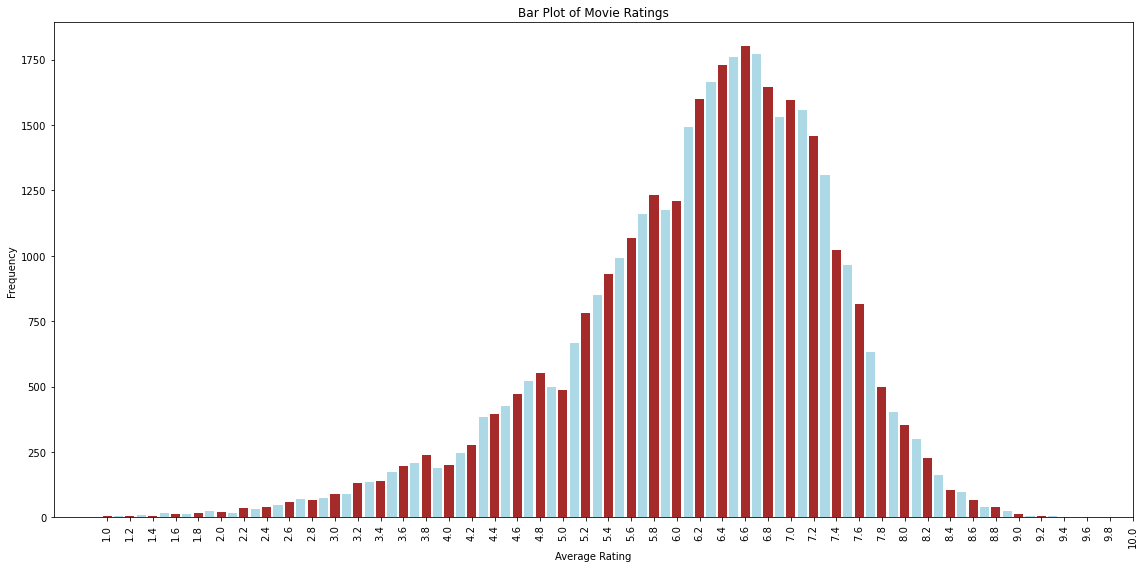

In [12]:
# Get value counts and sort them by rating
rating_counts = moviesData['averageRating'].value_counts().sort_index()

# Bar plot of movie ratings at 0.1 increments with alternating colors
colors = ['brown' if i % 2 == 0 else 'lightblue' for i in range(len(rating_counts))]
plt.figure(figsize=(16, 8))
plt.bar(rating_counts.index, rating_counts.values, width=0.08, color=colors)
plt.title('Bar Plot of Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(1, 10.1, 0.2), rotation=90)
plt.tight_layout()
plt.show()


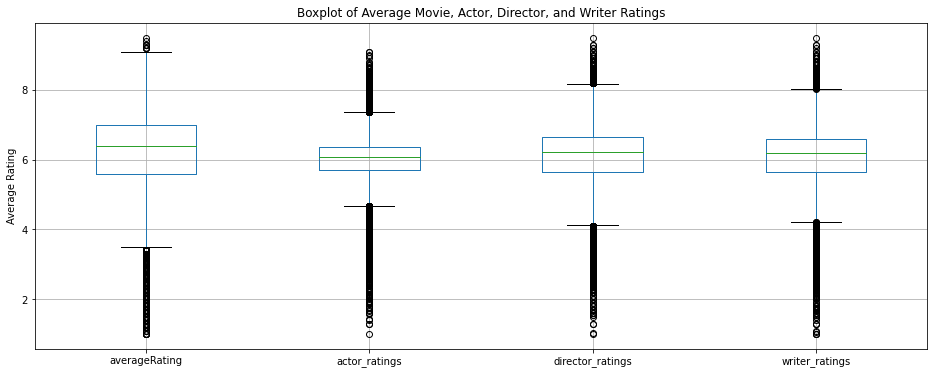

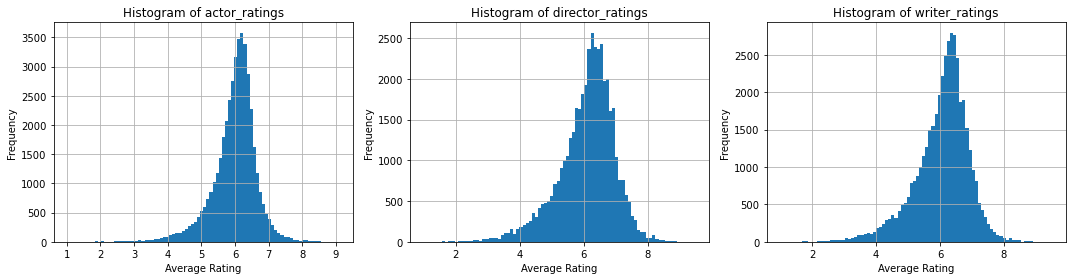

In [13]:
# Boxplots for actor, director, writer, and average movie ratings
plt.figure(figsize=(16, 6))
moviesData[['averageRating', 'actor_ratings', 'director_ratings', 'writer_ratings']].boxplot()
plt.title('Boxplot of Average Movie, Actor, Director, and Writer Ratings')
plt.ylabel('Average Rating')
plt.show()

# Histograms for actor, director, and writer ratings
plt.figure(figsize=(15, 4))
for i, col in enumerate(['actor_ratings', 'director_ratings', 'writer_ratings']):
    plt.subplot(1, 3, i+1)
    moviesData[col].hist(bins=88)
    plt.title(f'Histogram of {col}')
    plt.xlabel('Average Rating')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The actor ratings has the tightest spread, with director and writer being a little wider and also having a slightly greater median, but they each seem to follow a normal distribution with a high kurtosis. The boxplot corroborates this, but also appears to show many outliers. The higher spread for director and writer would likely be due to the fact that they have fewer movies than actors, thus are more sensitive to higher or lower ratings.

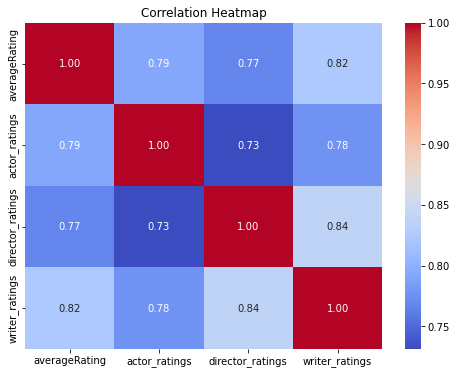

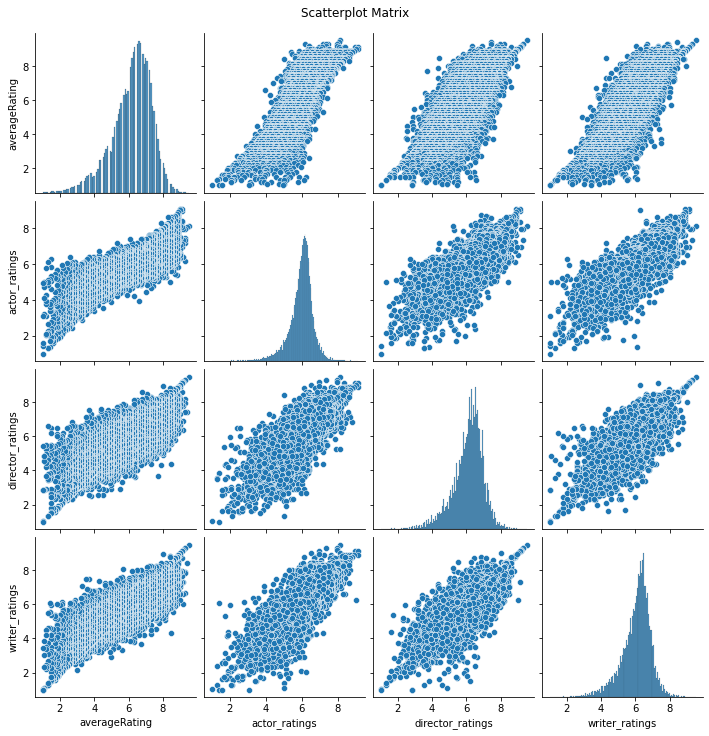

In [14]:
import seaborn as sns

# Compute correlation matrix for relevant numeric columns
corr = moviesData[['averageRating', 'actor_ratings', 'director_ratings', 'writer_ratings']].corr()

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Scatterplots for each pair of variables
sns.pairplot(moviesData[['averageRating', 'actor_ratings', 'director_ratings', 'writer_ratings']])
plt.suptitle('Scatterplot Matrix', y=1.02)
plt.show()

The scatterplots and heatmap seem to indicate a moderately positive linear correlation between all the ratings variables with each other, for average rating it shows a relationship which almost looks like the cube root with the other variables.  

### Genre Visualisations

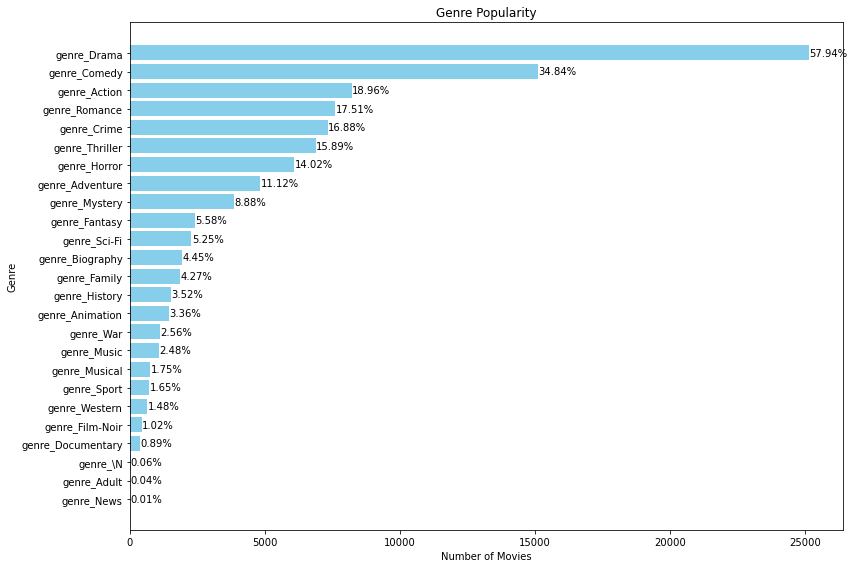

In [15]:
# Get all genre columns that start with 'genre_'
genre_columns = [col for col in moviesData.columns if col.startswith('genre_')]

# Calculate genre counts and percentages
genre_counts = moviesData[genre_columns].sum().sort_values()
genre_percent = (genre_counts / len(moviesData) * 100).round(2)

# Create a horizontal bar plot
plt.figure(figsize=(12, 8))
bars = plt.barh(genre_counts.index, genre_counts.values, color='skyblue')
plt.title('Genre Popularity')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')

# Annotate each bar with the percentage
for bar, pct in zip(bars, genre_percent):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
             f'{pct}%', va='center')

plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Average Rating by Genre'}>

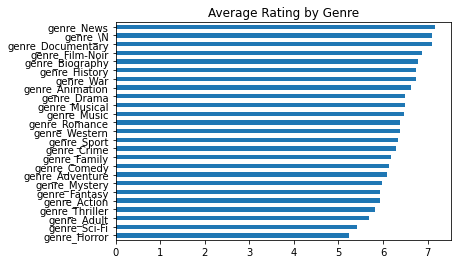

In [ ]:
#create a dictionary of average ratings for each genre
avg_ratings = {
    genre: moviesData[moviesData[genre] == 1]['averageRating'].mean()
    for genre in genre_columns
}

pd.Series(avg_ratings).sort_values().plot(kind='barh', title='Average Rating by Genre')

<AxesSubplot:>

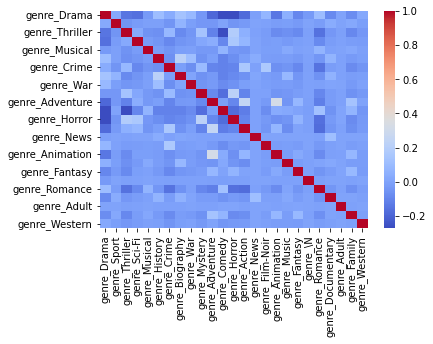

In [17]:
#heatmap of genre correlations
sns.heatmap(moviesData[list(genre_columns)].corr(), cmap='coolwarm', annot=False)

The heatmap shows that there is not any genre correlations, likely due to so many movies being present. However, we do notice on the horizontal bar charts that film-noir and documentary occur in very few movies and they have the highest rating, why might this be? We will explore further by seeing whether there is correlation to average rating and occurence in the data.

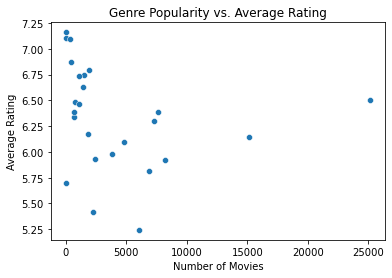

In [18]:
#creates a list of dictionaries with genre statistics to get genre averages, converts to dataframe
genre_stats = []

for genre in genre_columns:
    genre_movies = moviesData[moviesData[genre] == 1]
    genre_stats.append({
        'genre': genre,
        'count': genre_movies.shape[0],
        'average_rating': genre_movies['averageRating'].mean()
    })

genre_df = pd.DataFrame(genre_stats)

# Visualize the relationship
sns.scatterplot(data=genre_df, x='count', y='average_rating')
plt.title('Genre Popularity vs. Average Rating')
plt.xlabel('Number of Movies')
plt.ylabel('Average Rating')
plt.show()



This looks like it may have a negative linear relationship altough variance increases as number of movies increases, with our drama category being an outlier with regards to how many movies it appears in.  

### More Scatterplots of numerical variables

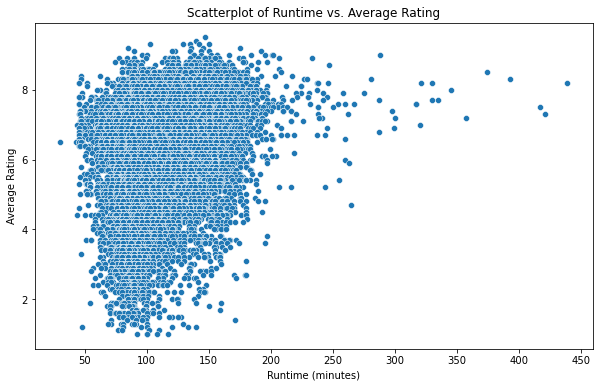

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=moviesData, x='Runtime', y='averageRating')
plt.title('Scatterplot of Runtime vs. Average Rating')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
plt.show()

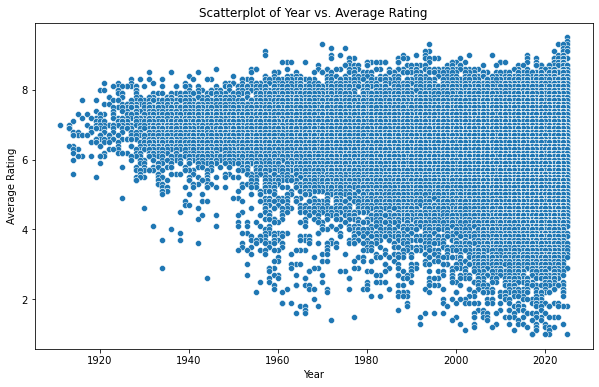

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=moviesData, x='Year', y='averageRating')
plt.title('Scatterplot of Year vs. Average Rating')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

There looks to be no relationship with runtime and average rating, and a strange relationship with year and rating, very clear heteroscedasticity as the variation greatly increases with year. There is clearly far more movies as time progresses, but earlier movies seem to receive a higher rating.

# Modelling - Linear

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

### Baseline Model - Linear Regression

Baseline model will include only the actor and crew ratings against the response, as these have the most apparent relationship, then we will do lasso regression to see if it improves. Once this is done we can start including the other predictors.

In [24]:
features = ['writer_ratings', 'director_ratings', 'actor_ratings'] 
X = moviesData[features]
y = moviesData['averageRating']

""" Splits, scales, trains a linear regression model, and returns predictions and objects.
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        test_size (float): Proportion of test set.
        random_state (int): Random seed.
    Returns:
        X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr
    """
def train_and_predict(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_test_scaled)
    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr

# Example usage:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr = train_and_predict(X, y)

#### Model Evaluation

In [25]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

#print the coefficients
coefficients = pd.Series(lr.coef_, index=features)
print("Coefficients:")
print(coefficients)

# print the predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())


RMSE: 0.586
R²: 0.749
Coefficients:
writer_ratings      0.478885
director_ratings    0.191414
actor_ratings       0.410057
dtype: float64
       Actual  Predicted
14095     6.8   6.121091
24634     6.2   6.264352
18379     6.6   6.179028
15801     6.7   6.444631
6293      7.3   7.375918


This baseline model says that my predictions are generally 0.586 away from their actual value and that 74.9% of variation in the target variable can be explained by my model.

### Residual Plots

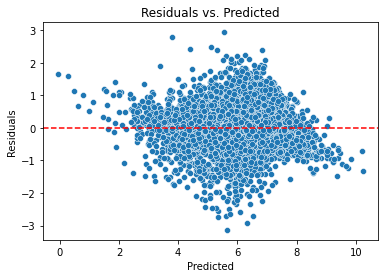

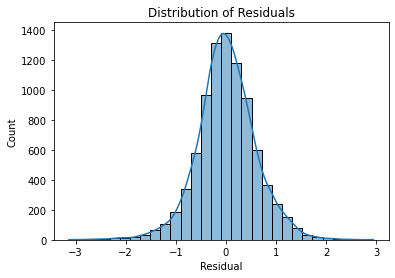

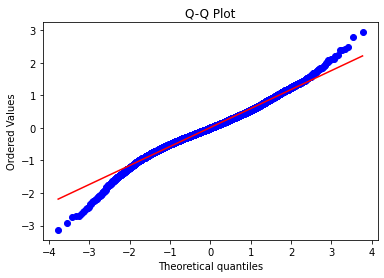

In [26]:
import scipy.stats as stats

residuals = y_test - y_pred

# 1. Residuals vs. Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()

# 3. Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

In the residuals vs predicted plot we don't see any significant pattern indicating non-linearity or non-constant variance of the residuals, they are evenly spread about the zero line. This indicates we don't need to do any transformations or interaction terms to handle non-linear relationships. 
For the distribution, they follow a normal distribution meaning we can use this model for inference, such as p-values or confidence intervals. 
Finally, the Q-Q plot shows the residual quantiles closely follow the red line with slight departures at the tails but nothing extreme. If tails are more extreme then often trying a non-parametric model such as tree based models can help.

## Linear Regression with Regularisation - Lasso Regression

In [27]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [28]:
# Set up Lasso with cross-validation to find the best alpha
lasso = Lasso(max_iter=10000)  # just in case your data needs more iterations
params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train_scaled, y_train)

# evalutation metrics: best alpha, RMSE, R², and coefficients
best_lasso = grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Best alpha: {grid.best_params_['alpha']}")
print(f"Lasso RMSE: {rmse_lasso:.3f}")
print(f"Lasso R²: {r2_lasso:.3f}")
print("Lasso Coefficients:", best_lasso.coef_)

Best alpha: 0.001
Lasso RMSE: 0.586
Lasso R²: 0.749
Lasso Coefficients: [0.47855572 0.19099917 0.40961473]


No performance change.

## Linear regression with Genre added 

In [29]:
# Create a new feature set including genre columns
genre_columns = [col for col in moviesData.columns if col.startswith('genre_')] 
features = ['writer_ratings', 'director_ratings', 'actor_ratings'] + genre_columns
X = moviesData[features]
y = moviesData['averageRating']

# train and predict with the new feature set
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr = train_and_predict(X, y)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

#print the coefficients
coefficients = pd.Series(lr.coef_, index=features)
print("Coefficients:")
print(coefficients)

# print the predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())


RMSE: 0.579
R²: 0.755
Coefficients:
writer_ratings       0.462531
director_ratings     0.189735
actor_ratings        0.400828
genre_Drama          0.031489
genre_Sport          0.005222
genre_Thriller      -0.020339
genre_Sci-Fi        -0.029134
genre_Musical        0.001888
genre_History        0.005137
genre_Crime          0.023710
genre_Biography      0.007295
genre_War            0.018781
genre_Mystery       -0.011259
genre_Adventure     -0.021914
genre_Comedy        -0.000143
genre_Horror        -0.015323
genre_Action        -0.014037
genre_News          -0.000449
genre_Film-Noir      0.015727
genre_Animation     -0.005833
genre_Music         -0.003030
genre_Fantasy       -0.020712
genre_\N            -0.007719
genre_Romance       -0.001771
genre_Documentary   -0.019628
genre_Adult          0.002762
genre_Family        -0.005117
genre_Western        0.005527
dtype: float64
       Actual  Predicted
14095     6.8   6.085116
24634     6.2   6.298926
18379     6.6   6.236351
15801    

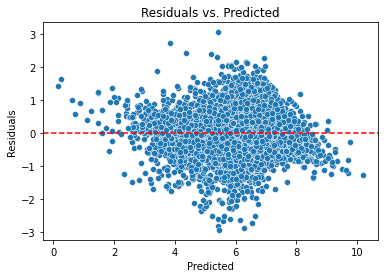

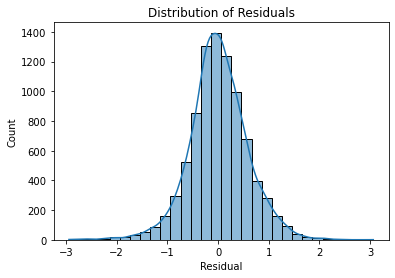

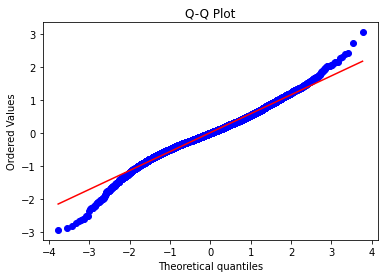

In [30]:
residuals = y_test - y_pred

# 1. Residuals vs. Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()

# 3. Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

## Lasso Regression with genres

In case we can bring any genres to 0 or see if any specifc genres have a stronger effect.

In [ ]:
lasso = Lasso(max_iter=10000)  # just in case your data needs more iterations
params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train_scaled, y_train)
best_lasso = grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Best alpha: {grid.best_params_['alpha']}")
print(f"Lasso RMSE: {rmse_lasso:.3f}")
print(f"Lasso R²: {r2_lasso:.3f}")

#print the coefficients
coefficients = pd.Series(best_lasso.coef_, index=features)
print("Coefficients:")
print(coefficients)

Best alpha: 0.001
Lasso RMSE: 0.579
Lasso R²: 0.755
Lasso Coefficients: [ 0.46262349  0.18915627  0.40043052  0.03220034  0.00443962 -0.01911543
 -0.02834319  0.00099472  0.00458922  0.02300743  0.00681042  0.01810525
 -0.01009518 -0.02128804  0.         -0.01457683 -0.01262443 -0.
  0.01510966 -0.00481421 -0.00170929 -0.01978643 -0.00660567 -0.
 -0.01819995  0.00178383 -0.00391492  0.00476672]


From the lasso model with genres, we can see that there is very marginal improvements to the model. There still may be some value in them if we can use clustering to reduce dimensionality or include some interaction terms.
We could possibly expand into SHAP values and feature importance.

## Lasso with Runtime and Genres 

In [33]:
features = ['writer_ratings', 'director_ratings', 'actor_ratings', 'Runtime'] + genre_columns
X = moviesData[features]
y = moviesData['averageRating']

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr = train_and_predict(X, y)
lasso = Lasso(max_iter=10000) 
params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train_scaled, y_train)
best_lasso = grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Best alpha: {grid.best_params_['alpha']}")
print(f"Lasso RMSE: {rmse_lasso:.3f}")
print(f"Lasso R²: {r2_lasso:.3f}")

#print the coefficients
coefficients = pd.Series(best_lasso.coef_, index=features)
print("Coefficients:")
print(coefficients)

Best alpha: 0.001
Lasso RMSE: 0.574
Lasso R²: 0.759
Coefficients:
writer_ratings       0.455158
director_ratings     0.180667
actor_ratings        0.399467
Runtime              0.066416
genre_Drama          0.025535
genre_Sport          0.003892
genre_Thriller      -0.020628
genre_Sci-Fi        -0.026442
genre_Musical       -0.001515
genre_History        0.000000
genre_Crime          0.024747
genre_Biography      0.002930
genre_War            0.016734
genre_Mystery       -0.010918
genre_Adventure     -0.020890
genre_Comedy         0.002398
genre_Horror        -0.008660
genre_Action        -0.025081
genre_News          -0.000000
genre_Film-Noir      0.020940
genre_Animation      0.002460
genre_Music         -0.001468
genre_Fantasy       -0.019779
genre_\N            -0.007519
genre_Romance       -0.003153
genre_Documentary   -0.013971
genre_Adult          0.002791
genre_Family        -0.003401
genre_Western        0.006785
dtype: float64


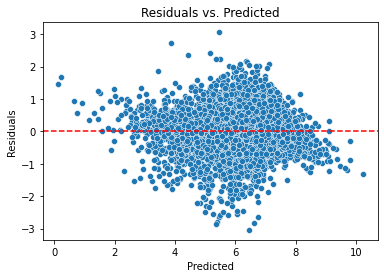

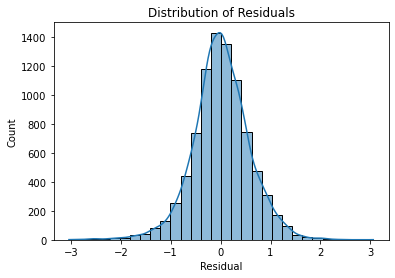

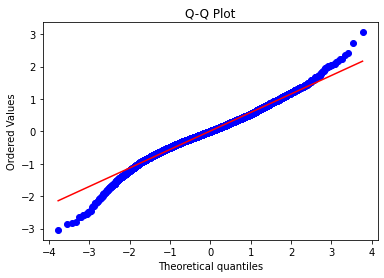

In [34]:
residuals = y_test - y_pred

# 1. Residuals vs. Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()

# 3. Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

## Lasso With All Variables

We are getting very marginal improvements for each additional variable. 

In [ ]:
features = ['writer_ratings', 'director_ratings', 'actor_ratings', 'Runtime', 'Year', 'numvotes'] + genre_columns
X = moviesData[features]
y = moviesData['averageRating']

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr = train_and_predict(X, y)

lasso = Lasso(max_iter=10000)
params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train_scaled, y_train)
best_lasso = grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test_scaled)

rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Best alpha: {grid.best_params_['alpha']}")
print(f"Lasso RMSE: {rmse_lasso:.3f}")
print(f"Lasso R²: {r2_lasso:.3f}")

#print the coefficients
coefficients = pd.Series(best_lasso.coef_, index=features)
print("Coefficients:")
print(coefficients)

Best alpha: 0.001
Lasso RMSE: 0.551
Lasso R²: 0.778
Coefficients:
writer_ratings       0.439455
director_ratings     0.160697
actor_ratings        0.387187
Runtime              0.084178
Year                -0.141273
numvotes             0.104462
genre_Drama          0.033952
genre_Sport          0.002626
genre_Thriller      -0.011465
genre_Sci-Fi        -0.044082
genre_Musical       -0.017305
genre_History       -0.000484
genre_Crime          0.010060
genre_Biography      0.001644
genre_War            0.001292
genre_Mystery       -0.012361
genre_Adventure     -0.048000
genre_Comedy         0.004296
genre_Horror        -0.017820
genre_Action        -0.024126
genre_News          -0.000000
genre_Film-Noir     -0.004673
genre_Animation      0.019666
genre_Music         -0.004178
genre_Fantasy       -0.026114
genre_\N            -0.003526
genre_Romance       -0.016253
genre_Documentary   -0.002656
genre_Adult          0.000011
genre_Family        -0.007970
genre_Western       -0.012637
dtyp

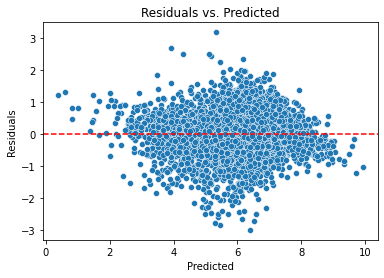

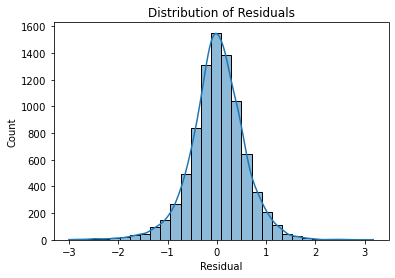

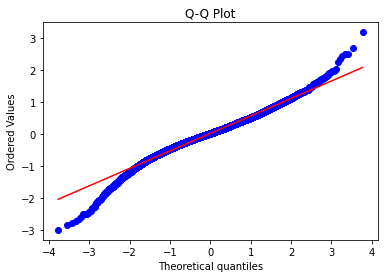

In [36]:
residuals = y_test - y_pred

# 1. Residuals vs. Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()

# 3. Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

With the inclusion of all variables performance got a decent increase. After adding year at the end it caused an increase in runtime coefficient and increased performance the most. Perhaps there is some interaction there that we need to explore, but year definitely has a good coefficient. 

We finish linear modelling with a current performance of 0.778 R-Squared and 0.551 for the RMSE.

# Modelling - Non-linear

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # no scaling needed for trees

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest R²: {r2_rf:.3f}")

Random Forest RMSE: 0.528
Random Forest R²: 0.796


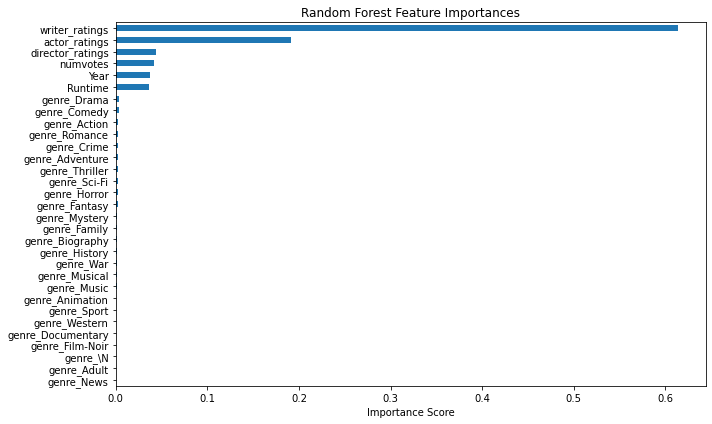

In [38]:
# Get feature importances and their labels
importances = rf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

# Plot
plt.figure(figsize=(10,6))
forest_importances.sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### XGBoost

In [43]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

base_features = ['writer_ratings', 'director_ratings', 'actor_ratings', 'Year', 'Runtime', 'numvotes'] + [col for col in moviesData.columns if col.startswith('genre_')]

X = moviesData[base_features]
y = moviesData['averageRating']

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, y_pred, lr = train_and_predict(X, y)

# Initialize and train the model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb:.3f}")
print(f"XGBoost R²: {r2_xgb:.3f}")

XGBoost RMSE: 0.517
XGBoost R²: 0.805


### With grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

xgb_model = xgb.XGBRegressor(random_state=42)

# Wrap in GridSearchCV
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# Best model
best_xgb = grid.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
rmse = mean_squared_error(y_test, y_pred_best, squared=False)
r2 = r2_score(y_test, y_pred_best)

print(f"Best Params: {grid.best_params_}")
print(f"Tuned XGBoost RMSE: {rmse:.3f}")
print(f"Tuned XGBoost R²: {r2:.3f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Tuned XGBoost RMSE: 0.516
Tuned XGBoost R²: 0.805


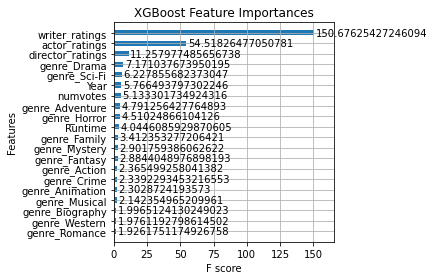

In [44]:
from xgboost import plot_importance

# Simple bar plot
plot_importance(xgb_model, importance_type='gain', max_num_features=20, height=0.5)
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()



Took significantly longer with a grid search and made no improvements. We have a our best model being the XGBoost, with RMSE: 0.517 and R²: 0.805